## Imports

In [ ]:
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision.io import read_image, ImageReadMode
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt

import time
import os

from tempfile import TemporaryDirectory

import re
def natural_sort_key(s):
    return [
        int(text) if text.isdigit() else text.lower() for text in re.split(r"(\d+)", s)
    ]

In [ ]:
# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf  '/content/drive/MyDrive/Marian/task1.tar.gz' -C '/content/data'

Streaming output truncated to the last 5000 lines.
task1/val_data/135.jpeg
task1/val_data/1295.jpeg
task1/val_data/3804.jpeg
task1/val_data/1324.jpeg
task1/val_data/56.jpeg
task1/val_data/2863.jpeg
task1/val_data/1266.jpeg
task1/val_data/3621.jpeg
task1/val_data/1145.jpeg
task1/val_data/196.jpeg
task1/val_data/4849.jpeg
task1/val_data/1666.jpeg
task1/val_data/3492.jpeg
task1/val_data/1322.jpeg
task1/val_data/2274.jpeg
task1/val_data/593.jpeg
task1/val_data/1267.jpeg
task1/val_data/4090.jpeg
task1/val_data/2643.jpeg
task1/val_data/542.jpeg
task1/val_data/2833.jpeg
task1/val_data/2903.jpeg
task1/val_data/2771.jpeg
task1/val_data/2154.jpeg
task1/val_data/3246.jpeg
task1/val_data/2750.jpeg
task1/val_data/266.jpeg
task1/val_data/3741.jpeg
task1/val_data/3274.jpeg
task1/val_data/1815.jpeg
task1/val_data/3662.jpeg
task1/val_data/4096.jpeg
task1/val_data/4148.jpeg
task1/val_data/1590.jpeg
task1/val_data/3851.jpeg
task1/val_data/2307.jpeg
task1/val_data/4380.jpeg
task1/val_data/4563.jpeg
task1/

In [ ]:
!tar -xvf  '/content/drive/MyDrive/Marian/task2.tar.gz' -C '/content/data'


Streaming output truncated to the last 5000 lines.
task2/val_data/135.jpeg
task2/val_data/1295.jpeg
task2/val_data/3804.jpeg
task2/val_data/1324.jpeg
task2/val_data/56.jpeg
task2/val_data/2863.jpeg
task2/val_data/1266.jpeg
task2/val_data/3621.jpeg
task2/val_data/1145.jpeg
task2/val_data/196.jpeg
task2/val_data/4849.jpeg
task2/val_data/1666.jpeg
task2/val_data/3492.jpeg
task2/val_data/1322.jpeg
task2/val_data/2274.jpeg
task2/val_data/593.jpeg
task2/val_data/1267.jpeg
task2/val_data/4090.jpeg
task2/val_data/2643.jpeg
task2/val_data/542.jpeg
task2/val_data/2833.jpeg
task2/val_data/2903.jpeg
task2/val_data/2771.jpeg
task2/val_data/2154.jpeg
task2/val_data/3246.jpeg
task2/val_data/2750.jpeg
task2/val_data/266.jpeg
task2/val_data/3741.jpeg
task2/val_data/3274.jpeg
task2/val_data/1815.jpeg
task2/val_data/3662.jpeg
task2/val_data/4096.jpeg
task2/val_data/4148.jpeg
task2/val_data/1590.jpeg
task2/val_data/3851.jpeg
task2/val_data/2307.jpeg
task2/val_data/4380.jpeg
task2/val_data/4563.jpeg
task2/

In [ ]:
DATA_PATH = os.path.join(os.getcwd(), "data")

TASK1_PATH = os.path.join(DATA_PATH, "task1")
TRAIN_TASK1 = os.path.join(TASK1_PATH, "train_data", "annotations.csv")
TRAIN_TASK1_UNLABELED = os.path.join(TASK1_PATH, "train_data", "images", "unlabeled")

VAL_TASK1 = os.path.join(TASK1_PATH, "val_data")

TASK2_PATH = os.path.join(DATA_PATH, "task2")
TRAIN_TASK2 = os.path.join(TASK2_PATH, "train_data", "annotations.csv")
VAL_TASK2 = os.path.join(TASK2_PATH, "val_data")

## Load data

In [ ]:
class LabeledData(Dataset):
    def __init__(self, annotation_file, transform=None) -> None:

        if isinstance(annotation_file,pd.DataFrame):
          self._annotations = annotation_file
        else:
          self._annotations = pd.read_csv(annotation_file)
          self._annotations ["sample"] = DATA_PATH + "/" + self._annotations["sample"]

        self.labels = self._annotations["label"]
        self.images_path = self._annotations["sample"]
        self.transform = transform

    def __getitem__(self, idx):
        _path_to_image = self.images_path[idx]
        image = Image.open(_path_to_image).convert("RGB")
        label = self.labels[idx].item()

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images_path)


class UnlabeledData(Dataset):
    def __init__(self, image_dir, transform=None) -> None:
        self.image_dir = image_dir
        self.images_path = sorted(os.listdir(image_dir), key=natural_sort_key)
        self.labels = [None for x in range(len(self.images_path))]
        self.transform = transform

    def __getitem__(self, idx):
        _path_to_image = os.path.join(self.image_dir, self.images_path[idx])
        image = Image.open(_path_to_image).convert("RGB")

        try:
            label = self.labels[idx].item()

        except:
            label = 1000

        if self.transform:
            image = self.transform(image)

        return image, label, _path_to_image

    def __len__(self):
        return len(self.images_path)


class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None) -> None:
        self.images_path = dataframe["sample"]
        self.labels = dataframe["label"]

        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.images_path.loc[idx]).convert("RGB")
        label = self.labels[idx].item()

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images_path)

In [ ]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        normalize,
    ]
)

transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(degrees=15),   # Rotate the image randomly by +/- 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change brightness, contrast, and saturation
    # Add more transformations as per your requirement
    transforms.ToTensor(),
    normalize,
])

In [ ]:
dataset = LabeledData(TRAIN_TASK1,transform=transform)

In [ ]:
dataset_unlabeled = UnlabeledData(TRAIN_TASK1_UNLABELED,transform=transform)

In [ ]:
def get_split_dataset(
    data,
    seed=42,
    test_size=0.2,
    batch_size = 64
):
    """Taken form https://stackoverflow.com/a/68338670"""

    # generate indices: instead of the actual data we pass in integers instead
    train_indices, test_indices, _, _ = train_test_split(
        range(len(data)),
        data.labels,
        stratify=data.labels,
        test_size=test_size,
        random_state=seed,
    )

    # generate subset based on indices
    train_split = Subset(data, train_indices)
    test_split = Subset(data, test_indices)

    # create batches
    train_batches = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    test_batches = DataLoader(test_split, batch_size=batch_size)


    return train_batches, test_batches, (len(train_indices), len(test_indices))

In [67]:
train_loader, valid_loader, dataset_sizes = get_split_dataset(dataset, batch_size=64)

In [ ]:
dataset_sizes

(18844, 4711)

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

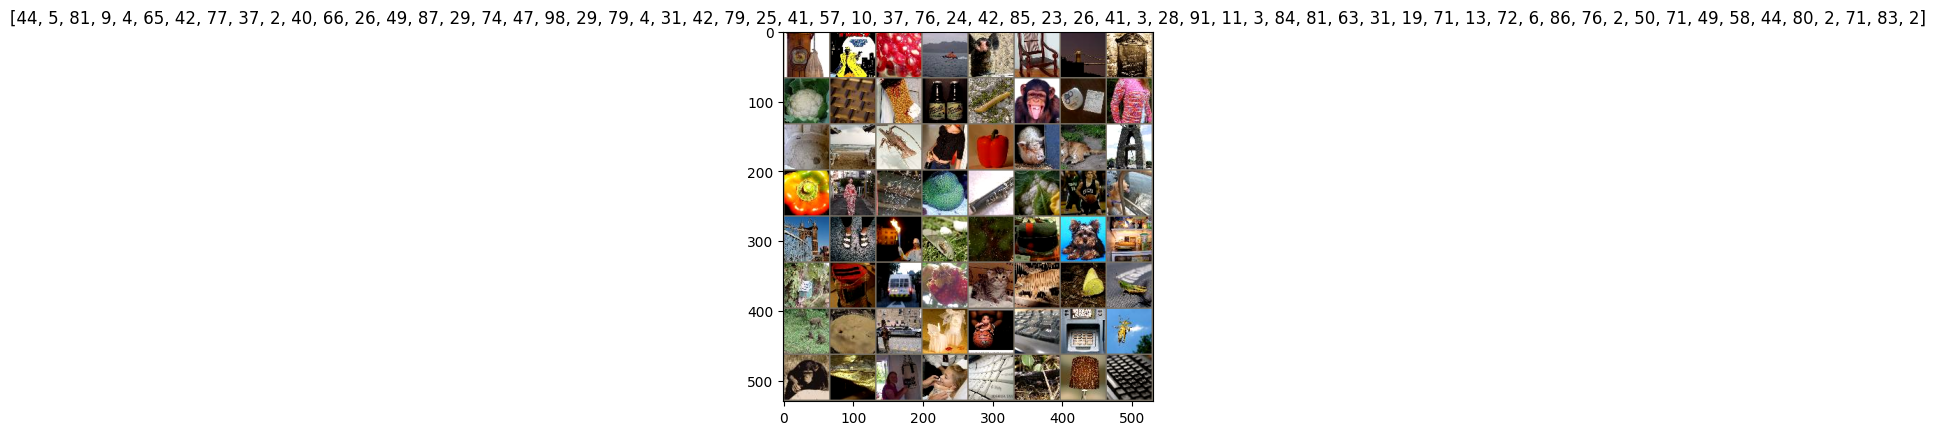

In [ ]:
def test_loader(dataloader, is_labeled=True):
    # Get a batch of training data

    if is_labeled:
        inputs, classes = next(iter(dataloader))
    else:
        inputs, classes, _ = next(iter(dataloader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[x.item() for x in classes])


test_loader(train_loader)

## Base model resnet50

In [ ]:
def train_model(
    model, criterion, optimizer, scheduler, train_loader, valid_loader, dataset_sizes,num_epochs=25
):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Training phase
            model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            scheduler.step()

            epoch_loss = running_loss / dataset_sizes[0]
            epoch_acc = running_corrects.float() / dataset_sizes[0]

            print(f"Train\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            print()

            model.eval()

            running_loss = 0.0
            running_corrects = 0
            # Validation phase
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[1]
            epoch_acc = running_corrects.float() / dataset_sizes[1]

            print(f"Valid\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    torch.save(model.state_dict(), "best_model_params.pt")

    return model

In [68]:
model_teacher = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_teacher.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_teacher.fc = nn.Linear(num_ftrs, 100)

model_teacher = model_teacher.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_teacher.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [70]:
model_teacher = train_model(
    model_teacher,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_loader,
    valid_loader,
    dataset_sizes,
    num_epochs=10
)

Epoch 0/9
----------
Train
	 Loss: 2.6912 Acc: 0.4497

Valid
	 Loss: 1.5472 Acc: 0.6211
Epoch 1/9
----------
Train
	 Loss: 1.2774 Acc: 0.6774

Valid
	 Loss: 1.2160 Acc: 0.6790
Epoch 2/9
----------
Train
	 Loss: 0.8865 Acc: 0.7689

Valid
	 Loss: 1.1306 Acc: 0.7062
Epoch 3/9
----------
Train
	 Loss: 0.6412 Acc: 0.8330

Valid
	 Loss: 1.0933 Acc: 0.7109
Epoch 4/9
----------
Train
	 Loss: 0.4642 Acc: 0.8805

Valid
	 Loss: 1.0945 Acc: 0.7158
Epoch 5/9
----------
Train
	 Loss: 0.3419 Acc: 0.9151

Valid
	 Loss: 1.0991 Acc: 0.7143
Epoch 6/9
----------
Train
	 Loss: 0.2527 Acc: 0.9398

Valid
	 Loss: 1.1179 Acc: 0.7177
Epoch 7/9
----------
Train
	 Loss: 0.1858 Acc: 0.9600

Valid
	 Loss: 1.1134 Acc: 0.7202
Epoch 8/9
----------
Train
	 Loss: 0.1793 Acc: 0.9620

Valid
	 Loss: 1.1178 Acc: 0.7183
Epoch 9/9
----------
Train
	 Loss: 0.1713 Acc: 0.9632

Valid
	 Loss: 1.1117 Acc: 0.7215
Training complete in 5m 47s
Best val Acc: 0.721503


In [ ]:
import re
from tqdm import tqdm
from pathlib import Path


def predict(model, transform, img_path, base_dir=""):
    img = Image.open(os.path.join(base_dir, img_path)).convert("RGB")
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

    return preds[0].item()


def write_submission(data: pd.DataFrame, task_name: str = None, filename: str = None):
    submission_dir = os.path.join(DATA_PATH, "submission", task_name)

    if task_name not in ["task1", "task2"]:
        raise TypeError(
            "Task name is mandatory and can have the value: Task1 or Task2."
        )

    if not Path(submission_dir).exists():
        os.makedirs(submission_dir)

    if filename is None:
        filename = "submission"


    _filename = os.path.join(
        DATA_PATH, submission_dir, filename + ".csv"
    )

    index = 1
    while os.path.exists(_filename):
        _filename = os.path.join(
            DATA_PATH, submission_dir, filename + "_" + str(index) + ".csv"
        )
        index = index + 1

    data.to_csv(_filename, index=False)


def create_data(dictionary: dict):
    df = pd.DataFrame.from_dict(dictionary, orient="index")
    df.reset_index(inplace=True)
    df.columns = ["sample", "label"]

    return df


def create_submission(
    model, transform=None, task_name: str = None, valid_dir: str = None
):
    if valid_dir is None:
        raise TypeError("The path must be str")

    image_paths = sorted(os.listdir(valid_dir), key=natural_sort_key)

    valid_dict = {}
    for img_path in tqdm(image_paths, desc="Predict images"):
        valid_dict[img_path] = predict(model, transform, img_path, valid_dir)

    data = create_data(valid_dict)

    write_submission(data, task_name)

In [ ]:
create_submission(model_teacher, transform, "task1", VAL_TASK1)

Predict images: 100%|██████████| 5000/5000 [00:47<00:00, 104.99it/s]


### Task2

In [ ]:
dataset_task2 = LabeledData(TRAIN_TASK2, transform=transform)

In [ ]:
dataset_task2.labels.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
train_loader_task2, valid_loader_task2 = get_split_dataset(dataset_task2, batch_size=64)

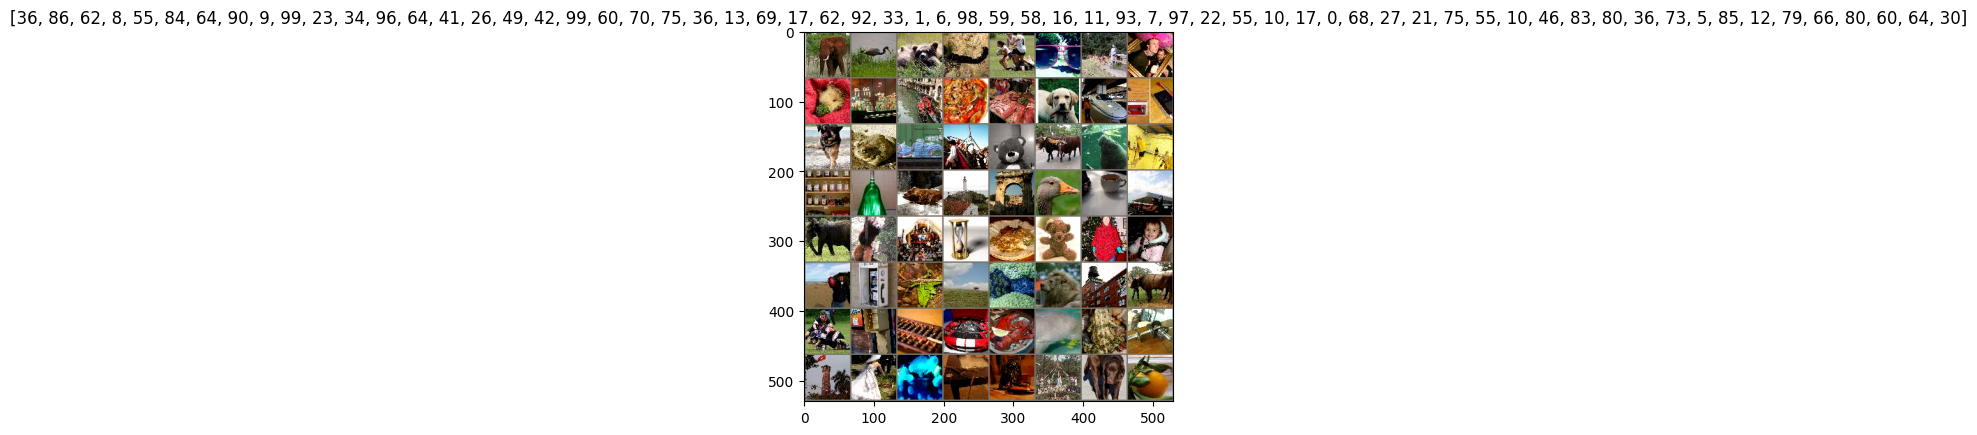

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(train_loader_task2))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x.item() for x in classes])

In [ ]:
model_task2 = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_task2.fc = nn.Linear(num_ftrs, 100)

model_task2 = model_task2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_task2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_task2 = train_model(
    model_task2, criterion, optimizer_ft, exp_lr_scheduler, train_loader_task2,valid_loader_task2,num_epochs=10
)

Epoch 0/9
----------
Train
	 Loss: 166.3826 Acc: 25.4256

Valid
	 Loss: 103.1278 Acc: 36.2102
Epoch 1/9
----------
Train
	 Loss: 92.1135 Acc: 37.8400

Valid
	 Loss: 91.7004 Acc: 37.7580
Epoch 2/9
----------
Train
	 Loss: 71.8360 Acc: 42.3344

Valid
	 Loss: 89.1167 Acc: 38.0955
Epoch 3/9
----------
Train
	 Loss: 57.7620 Acc: 45.9344

Valid
	 Loss: 89.0988 Acc: 37.9682
Epoch 4/9
----------
Train
	 Loss: 46.5798 Acc: 48.9728

Valid
	 Loss: 89.9065 Acc: 38.0892
Epoch 5/9
----------
Train
	 Loss: 37.3577 Acc: 51.8224

Valid
	 Loss: 92.6628 Acc: 37.7452
Epoch 6/9
----------
Train
	 Loss: 30.1634 Acc: 54.3184

Valid
	 Loss: 95.6747 Acc: 37.2229
Epoch 7/9
----------
Train
	 Loss: 22.9331 Acc: 57.1904

Valid
	 Loss: 94.8249 Acc: 37.6306
Epoch 8/9
----------
Train
	 Loss: 22.0988 Acc: 57.5648

Valid
	 Loss: 95.2804 Acc: 37.5287
Epoch 9/9
----------
Train
	 Loss: 21.1712 Acc: 57.8880

Valid
	 Loss: 95.1015 Acc: 37.8153
Training complete in 35m 17s
Best val Acc: 38.095543


In [ ]:
create_submission(model_task2,transform,"task2",VAL_TASK2)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:27<00:00, 57.29it/s]


## Implement MPL
Meta Pseudo Learning


In [ ]:
import copy

In [ ]:
teacher_model = copy.deepcopy(model_teacher)

CONFIDENCE = 0.80

# teacher_model.eval()

In [ ]:
unlabeled_loader = DataLoader(dataset_unlabeled,batch_size=32,shuffle=True)


In [ ]:
def generate_pseudo_labels(teacher_model, dataloader, confidences_threshold=0.8):
    # Store pseudo-labeled data
    pseudo_labeled_data = []

    teacher_model.eval()
    with torch.no_grad():
        for images, _, img_paths in tqdm(dataloader, desc="Generate PSEUDO-LABELS"):
            images = images.to(device)
            outputs = teacher_model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidences, pseudo_labels = torch.max(probabilities, dim=1)

            # Filter out low confidence predictions
            high_confidence_mask = confidences > confidences_threshold

            high_confidence_images = images[high_confidence_mask]
            high_confidence_labels = pseudo_labels[high_confidence_mask]
            high_confidence_paths = [
                img_paths[i] for i in range(len(img_paths)) if high_confidence_mask[i]
            ]

            for img, path, label in zip(
                high_confidence_images, high_confidence_paths, high_confidence_labels
            ):
                pseudo_labeled_data.append((img.cpu(), path, label.cpu()))

    pseudo_labels_dict = {
        "sample": [row[1] for row in pseudo_labeled_data],
        "label": [row[2].item() for row in pseudo_labeled_data],
    }

    df_pseudo = pd.DataFrame(pseudo_labels_dict)

    print(f"Generated new {len(df_pseudo)} pseudo labels")

    return df_pseudo

In [ ]:
def create_combined_dataframe(data_path_1: str or Path, data_2: pd.DataFrame):
    df_labeled = pd.read_csv(data_path_1)

    df_labeled["sample"] = DATA_PATH + "/" + df_labeled["sample"]

    return pd.concat([df_labeled, data_2], ignore_index=True)

In [ ]:
student_model = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = student_model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
student_model.fc = nn.Linear(num_ftrs, 100)

student_model = student_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
stud = train_model(
    student_model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_combined,
    test_combined,
    num_epochs=8,
)

Epoch 0/7
----------
Train
	 Loss: 136.1147 Acc: 35.4283

Valid
	 Loss: 57.2219 Acc: 49.4524
Epoch 1/7
----------
Train
	 Loss: 48.6227 Acc: 51.6036

Valid
	 Loss: 46.1460 Acc: 51.7063
Epoch 2/7
----------
Train
	 Loss: 31.6833 Acc: 55.6056

Valid
	 Loss: 44.1124 Acc: 52.3968
Epoch 3/7
----------
Train
	 Loss: 22.2286 Acc: 58.0239

Valid
	 Loss: 41.9007 Acc: 52.8254
Epoch 4/7
----------
Train
	 Loss: 15.4638 Acc: 60.0578

Valid
	 Loss: 42.2423 Acc: 53.0238
Epoch 5/7
----------
Train
	 Loss: 11.3930 Acc: 61.0319

Valid
	 Loss: 42.9054 Acc: 52.8810
Epoch 6/7
----------
Train
	 Loss: 8.3247 Acc: 61.9263

Valid
	 Loss: 43.6183 Acc: 53.0397
Epoch 7/7
----------
Train
	 Loss: 6.0641 Acc: 62.5498

Valid
	 Loss: 43.8548 Acc: 52.6746
Training complete in 31m 47s
Best val Acc: 53.039684


In [ ]:
create_submission(student_model, transform, "task1", VAL_TASK1)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:52<00:00, 44.52it/s]


### Implement Noisy Student

In [ ]:
# student_noisy_model =
student_noisy_model = models.resnet50(weights="IMAGENET1K_V2")

num_ftrs = student_noisy_model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
student_noisy_model.fc = nn.Linear(num_ftrs, 100)

# # Freeze all layers except the last two
# for param in student_noisy_model.parameters():
#     param.requires_grad = False
# for param in student_noisy_model.fc.parameters():
#     param.requires_grad = True

student_noisy_model = student_noisy_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(student_noisy_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
pseudo_labels = generate_pseudo_labels(model_teacher, unlabeled_loader,confidences_threshold=0.95)

combined_data = create_combined_dataframe(TRAIN_TASK1, pseudo_labels)

augmented_data = CustomDataset(combined_data, transform_augmented)

augmented_loader = DataLoader(augmented_data, batch_size=64, shuffle=True)

Generate PSEUDO-LABELS: 100%|██████████| 827/827 [00:46<00:00, 17.85it/s]

Generated new 11673 pseudo labels
<class 'pandas.core.frame.DataFrame'>


In [ ]:
student_noisy_model = train_model(
    student_noisy_model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    augmented_loader,
    valid_loader,
    num_epochs=10,
)

Epoch 0/9
----------
Train
	 Loss: 258.9727 Acc: 8.8276

Valid
	 Loss: 237.0605 Acc: 18.1892
Epoch 1/9
----------
Train
	 Loss: 188.7072 Acc: 20.8929

Valid
	 Loss: 274.7428 Acc: 14.5811
Epoch 2/9
----------
Train
	 Loss: 166.9696 Acc: 24.5172

Valid
	 Loss: 230.7163 Acc: 17.6892
Epoch 3/9
----------
Train
	 Loss: 155.8068 Acc: 26.7296

Valid
	 Loss: 200.5780 Acc: 22.6892
Epoch 4/9
----------
Train
	 Loss: 148.6182 Acc: 28.0018

Valid
	 Loss: 138.6353 Acc: 33.2297
Epoch 5/9
----------
Train
	 Loss: 143.4343 Acc: 29.0000

Valid
	 Loss: 139.6150 Acc: 33.3378
Epoch 6/9
----------
Train
	 Loss: 139.0712 Acc: 30.1071

Valid
	 Loss: 134.3980 Acc: 34.2432
Epoch 7/9
----------
Train
	 Loss: 134.5340 Acc: 30.9238

Valid
	 Loss: 140.1589 Acc: 33.3378
Epoch 8/9
----------
Train
	 Loss: 133.9809 Acc: 31.1470

Valid
	 Loss: 128.2362 Acc: 34.9189
Epoch 9/9
----------
Train
	 Loss: 132.5675 Acc: 31.1670

Valid
	 Loss: 131.1515 Acc: 35.0000
Training complete in 28m 26s
Best val Acc: 35.000000


In [ ]:
teacher_model_iter = copy.deepcopy(model_teacher)

for _ in tqdm(range(3)):
    pseudo_labels = generate_pseudo_labels(teacher_model_iter, unlabeled_loader)

    combined_data = create_combined_dataframe(TRAIN_TASK1, pseudo_labels)

    augmented_data = CustomDataset(combined_data, transform_augmented)

    augmented_loader = DataLoader(augmented_data, batch_size=64, shuffle=True)

    student_noisy_model = train_model(
        student_noisy_model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        augmented_loader,
        valid_loader,
        num_epochs=15,
    )

    teacher_model_iter = student_noisy_model

In [ ]:
create_submission(student_noisy_model, transform, "task1", VAL_TASK1)

Predict images: 100%|██████████| 5000/5000 [01:38<00:00, 50.89it/s]


In [ ]:
def evaluate_model(model, criterion, valid_loader,valid_size ,title: str = "Model"):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(predicted == labels.data)

    epoch_loss = running_loss / valid_size
    epoch_acc = running_corrects.float() / valid_size

    print(f"Valid {title}\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return epoch_acc


def train_noisy_student(
    teacher,
    student,
    criterion_teacher,
    optimizer_teacher,
    scheduler_teacher,
    criterion_student,
    optimizer_student,
    scheduler_student,
    train_loader,
    valid_loader,
    dataset_sizes,
    valid_size,
    unlabeled_loader,
    num_epochs=25,
):
    teacher.to(device)
    student.to(device)

    # Train the model
    best_acc = 0.0
    best_model = None
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        running_loss_teacher = 0.0
        running_corrects_teacher = 0

        running_loss_student = 0.0
        running_corrects_student = 0

        student.train()
        teacher.train()

        for labeled_data, labels in train_loader:
            labeled_data = labeled_data.to(device)
            labels = labels.to(device)

            # Train on labeled data
            optimizer_teacher.zero_grad()
            outputs = teacher(labeled_data)
            _, preds = torch.max(outputs, 1)
            loss_teacher = criterion_teacher(outputs, labels)
            loss_teacher.backward()
            optimizer_teacher.step()

            teacher.eval()
            # Generate pseudo-labels for unlabeled data
            with torch.no_grad():
                unlabeled_data, _, _ = next(iter(unlabeled_loader))
                unlabeled_data = unlabeled_data.to(device)
                outputs = teacher(unlabeled_data)
                confidences, pseudo_labels = torch.max(outputs, 1)

                high_confidence_mask = confidences > 0.90
                unlabeled_data = unlabeled_data[high_confidence_mask]
                pseudo_labels = pseudo_labels[high_confidence_mask]

            # Train on labeled and pseudo-labeled data
            # Student model
            optimizer_student.zero_grad()
            labeled_outputs = student(labeled_data)
            unlabeled_outputs = student(unlabeled_data)
            loss_student = criterion_student(
                labeled_outputs, labels
            ) + criterion_student(unlabeled_outputs, pseudo_labels)
            loss_student.backward()
            optimizer_student.step()

            running_loss_teacher += loss_teacher.item() * labeled_data.size(0)
            running_corrects_teacher += torch.sum(preds == labels.data)

            # running_loss_student += loss.item() * labeled_data.size(0)
            # running_corrects_student += torch.sum(preds == labels.data)

        scheduler_teacher.step()
        scheduler_student.step()

        epoch_loss = running_loss_teacher / dataset_sizes[0]
        epoch_acc = running_corrects_teacher.float() / dataset_sizes[0]

        print(f"Train\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        teacher_acc = evaluate_model(
            teacher, criterion_teacher, valid_loader,valid_size,"Teacher"
        )
        student_acc = evaluate_model(
            student, criterion_teacher, valid_loader,valid_size, "Student"
        )

        if teacher_acc > best_acc:
            best_acc = teacher_acc
            best_model = teacher
            # torch.save(teacher.state_dict(), "best_noisy_model.pt")
        elif student_acc > best_acc:
            best_acc = student_acc
            best_model = student
            # torch.save(student.state_dict(), "best_noisy_model.pt")

        if student_acc > teacher_acc and student_acc > best_acc:
            print("Update parameters teacher")
            teacher.load_state_dict(student.state_dict())

    # best_model.load_state_dict(torch.load("best_noisy_model.pt"))

    return best_model

In [ ]:
# model_teacher = models.resnet50(weights="IMAGENET1K_V2")
# num_ftrs = model_teacher.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_teacher.fc = nn.Linear(num_ftrs, 100)

# model_teacher = model_teacher.to(device)

criterion_teacher = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_teacher = optim.SGD(model_teacher.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_teacher = lr_scheduler.StepLR(optimizer_teacher, step_size=7, gamma=0.1)

In [ ]:
# Define the fine-tuning model
student_noisy_model = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_teacher.fc.in_features
# Replace the last fully connected layer with a linear layer with 10 output features for CIFAR-10
student_noisy_model.fc = nn.Linear(num_ftrs, 100)

# Define the loss function and optimizer
criterion_student = nn.CrossEntropyLoss()
optimizer_student = optim.SGD(student_noisy_model.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_student = lr_scheduler.StepLR(
    optimizer_student, step_size=7, gamma=0.1
)

# Define the data transforms
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
transform_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Load the labeled data
dataset = LabeledData(TRAIN_TASK1, transform=transform)
trainset, testset = get_split_dataset(dataset, batch_size=128)

# Load the unlabeled data
unlabeledset = UnlabeledData(TRAIN_TASK1_UNLABELED, transform=transform)
unlabeledloader = DataLoader(unlabeledset, batch_size=128, shuffle=True)

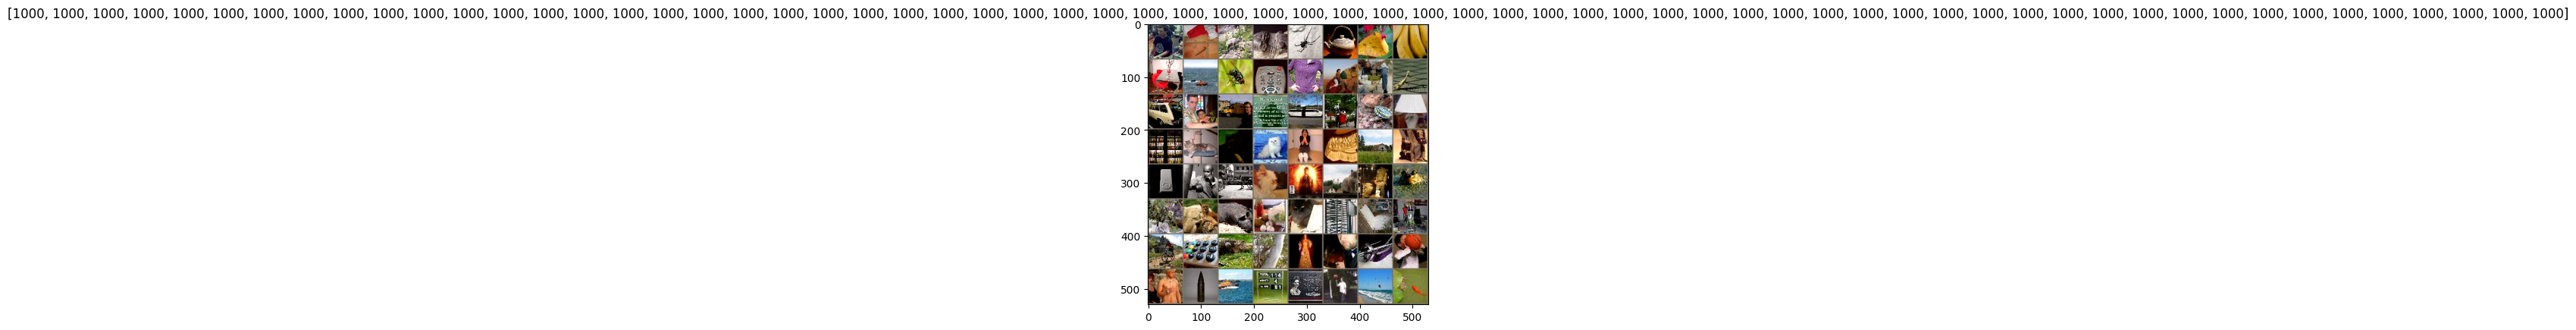

In [ ]:
test_loader(unlabeledloader, is_labeled=False
            )

In [ ]:
model = train_noisy_student(
    model_teacher,
    student_noisy_model,
    criterion_teacher,
    optimizer_teacher,
    exp_lr_scheduler_teacher,
    criterion_student,
    optimizer_student,
    exp_lr_scheduler_student,
    trainset,
    testset,
    unlabeledloader,
    15,
)

Epoch 0/14
----------
Train
	 Loss: 1.6412 Acc: 63.8441
Valid Teacher
	 Loss: 70.6978 Acc: 46.3243
Valid Student
	 Loss: 65.0296 Acc: 47.3649
Update parameters teacher
Epoch 1/14
----------
Train
	 Loss: 5.3844 Acc: 63.0136
Valid Teacher
	 Loss: 64.9708 Acc: 47.3514
Valid Student
	 Loss: 65.3422 Acc: 47.2838
Epoch 2/14
----------
Train
	 Loss: 5.3006 Acc: 63.0407
Valid Teacher
	 Loss: 64.6481 Acc: 47.4324
Valid Student
	 Loss: 64.4404 Acc: 47.5270
Update parameters teacher
Epoch 3/14
----------
Train
	 Loss: 5.1080 Acc: 63.0746
Valid Teacher
	 Loss: 64.5908 Acc: 47.5000
Valid Student
	 Loss: 65.7277 Acc: 47.1757
Epoch 4/14
----------
Train
	 Loss: 5.0561 Acc: 63.0915
Valid Teacher
	 Loss: 64.8231 Acc: 47.5270
Valid Student
	 Loss: 66.5526 Acc: 46.9730
Epoch 5/14
----------
Train
	 Loss: 5.0274 Acc: 63.0915
Valid Teacher
	 Loss: 64.7854 Acc: 47.5676
Valid Student
	 Loss: 64.9001 Acc: 47.1622
Epoch 6/14
----------
Train
	 Loss: 4.9918 Acc: 63.0915
Valid Teacher
	 Loss: 64.6847 Acc: 47.64

In [ ]:
create_submission(model, transform, "task1", VAL_TASK1)

Predict images: 100%|██████████| 5000/5000 [00:47<00:00, 104.93it/s]


In [46]:
def evaluate_model(model, criterion, valid_loader, dataset_size,title: str = "Model"):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(predicted == labels.data)

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.float() / dataset_size

    print(f"Valid {title}\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return epoch_acc


def train_simple(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    dataset_size ,
    num_epochs=3,
    title="Training...",
):
    # Create a temporary directory to save training checkpoints

    model.to(device)

    print(f"Training {title} ...")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Training phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.float() / dataset_size

        print(f"Train\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return model


def train_mlp(
    teacher_model,
    student_model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    unlabeled_loader,
    valid_loader,
    dataset_sizes,
    num_epochs=25,
):
    since = time.time()
    best_model = teacher_model

    best_acc = 0

    for epoch in range(num_epochs):

        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # 1. Train Teacher Model on Labeled Data
        # teacher_model = train_simple(
        #     teacher_model, criterion, optimizer, scheduler, train_loader,3,"Training teacher..."
        # )

        # 2. Generate Pseudo Labels for Unlabeled Data
        pseudo_labels = generate_pseudo_labels(teacher_model, unlabeled_loader, 0.99)

        pseudo_dataset = LabeledData(pseudo_labels,transform_augmented)
        labeled_dataset = LabeledData(TRAIN_TASK1,transform)

        # 3. Combine Pseudo Labels with Labeled Data
        # combined_data = create_combined_dataframe(TRAIN_TASK1, pseudo_labels)

        combined_data = torch.utils.data.ConcatDataset([pseudo_dataset, labeled_dataset])
        combined_loader = DataLoader(combined_data, batch_size=256, shuffle=True)

        dataset_size = len(combined_data)
        # 4. Train Student Model on Combined Data
        student_model = train_simple(
            student_model, criterion, optimizer, scheduler, combined_loader, dataset_size,7,"Training student..."
        )

        # 5. Evaluate Student Model
        student_acc = evaluate_model(student_model,criterion,valid_loader,dataset_sizes[1],"Student")
        teacher_acc = evaluate_model(teacher_model, criterion,valid_loader,dataset_sizes[1],"Teacher")

        # 6. Update Teacher Model based on Student's Performance
        # 7. Save Best Student Model
        if student_acc > teacher_acc and student_acc > best_acc:
            best_acc = student_acc
            print("Update parameters teacher")
            teacher_model.load_state_dict(student_model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # Load best student model weights

    return teacher_model, student_model

In [ ]:
pseudo_labels = generate_pseudo_labels(model_teacher, unlabeledloader, 0.9)

pseudo_dataset = LabeledData(pseudo_labels,transform_augmented)
labeled_dataset = LabeledData(TRAIN_TASK1,transform)

# 3. Combine Pseudo Labels with Labeled Data
# combined_data = create_combined_dataframe(TRAIN_TASK1, pseudo_labels)

combined_data = torch.utils.data.ConcatDataset([pseudo_dataset, labeled_dataset])
dataset_size = len(combined_data)
combined_loader = DataLoader(augmented_data, batch_size=64, shuffle=True)

Generate PSEUDO-LABELS: 100%|██████████| 207/207 [00:26<00:00,  7.87it/s]


Generated new 16824 pseudo labels


In [ ]:
student_model = train_simple(
    model_teacher, criterion, optimizer_ft, exp_lr_scheduler, combined_loader, dataset_size,3,"Training student..."
)

NameError: name 'combined_loader' is not defined

In [ ]:
import copy
model_student = copy.deepcopy(model_teacher)

In [ ]:
# Load the labeled data
dataset = LabeledData(TRAIN_TASK1, transform=transform)
trainset, testset ,data_size = get_split_dataset(dataset, batch_size=256)

# Load the unlabeled data
unlabeledset = UnlabeledData(TRAIN_TASK1_UNLABELED, transform=transform)
unlabeledloader = DataLoader(unlabeledset, batch_size=256, shuffle=True)

In [47]:
model_list = train_mlp(model_teacher, model_student,criterion,optimizer_ft,exp_lr_scheduler,trainset,unlabeledloader,testset,dataset_sizes,10)

Epoch 0/9
----------


Generate PSEUDO-LABELS: 100%|██████████| 104/104 [00:24<00:00,  4.19it/s]


Generated new 8040 pseudo labels
Training Training student... ...
Epoch 0/6
----------
Train
	 Loss: 0.2861 Acc: 0.9306
Epoch 1/6
----------
Train
	 Loss: 0.2841 Acc: 0.9320
Epoch 2/6
----------
Train
	 Loss: 0.2907 Acc: 0.9303
Epoch 3/6
----------
Train
	 Loss: 0.2830 Acc: 0.9326
Epoch 4/6
----------
Train
	 Loss: 0.2860 Acc: 0.9303
Epoch 5/6
----------
Train
	 Loss: 0.2886 Acc: 0.9307
Epoch 6/6
----------
Train
	 Loss: 0.2887 Acc: 0.9305
Valid Student
	 Loss: 1.0875 Acc: 0.7306
Valid Teacher
	 Loss: 1.1107 Acc: 0.7300
Update parameters teacher
Epoch 1/9
----------


Generate PSEUDO-LABELS: 100%|██████████| 104/104 [00:24<00:00,  4.18it/s]


Generated new 8184 pseudo labels
Training Training student... ...
Epoch 0/6
----------
Train
	 Loss: 0.2868 Acc: 0.9308
Epoch 1/6
----------
Train
	 Loss: 0.2835 Acc: 0.9307
Epoch 2/6
----------
Train
	 Loss: 0.2871 Acc: 0.9300
Epoch 3/6
----------
Train
	 Loss: 0.2882 Acc: 0.9319
Epoch 4/6
----------
Train
	 Loss: 0.2862 Acc: 0.9316
Epoch 5/6
----------
Train
	 Loss: 0.2887 Acc: 0.9303
Epoch 6/6
----------
Train
	 Loss: 0.2851 Acc: 0.9315
Valid Student
	 Loss: 1.0927 Acc: 0.7304
Valid Teacher
	 Loss: 1.0875 Acc: 0.7306
Epoch 2/9
----------


Generate PSEUDO-LABELS: 100%|██████████| 104/104 [00:24<00:00,  4.20it/s]


Generated new 8184 pseudo labels
Training Training student... ...
Epoch 0/6
----------
Train
	 Loss: 0.2841 Acc: 0.9317
Epoch 1/6
----------
Train
	 Loss: 0.2863 Acc: 0.9320
Epoch 2/6
----------
Train
	 Loss: 0.2847 Acc: 0.9313
Epoch 3/6
----------
Train
	 Loss: 0.2843 Acc: 0.9320
Epoch 4/6
----------
Train
	 Loss: 0.2857 Acc: 0.9315
Epoch 5/6
----------
Train
	 Loss: 0.2855 Acc: 0.9324
Epoch 6/6
----------
Train
	 Loss: 0.2820 Acc: 0.9318
Valid Student
	 Loss: 1.0942 Acc: 0.7277
Valid Teacher
	 Loss: 1.0875 Acc: 0.7306
Epoch 3/9
----------


Generate PSEUDO-LABELS: 100%|██████████| 104/104 [00:24<00:00,  4.22it/s]


Generated new 8184 pseudo labels
Training Training student... ...
Epoch 0/6
----------
Train
	 Loss: 0.2865 Acc: 0.9315
Epoch 1/6
----------
Train
	 Loss: 0.2864 Acc: 0.9316
Epoch 2/6
----------
Train
	 Loss: 0.2837 Acc: 0.9318
Epoch 3/6
----------
Train
	 Loss: 0.2916 Acc: 0.9309
Epoch 4/6
----------
Train
	 Loss: 0.2883 Acc: 0.9315
Epoch 5/6
----------
Train
	 Loss: 0.2843 Acc: 0.9319
Epoch 6/6
----------
Train
	 Loss: 0.2850 Acc: 0.9320
Valid Student
	 Loss: 1.0902 Acc: 0.7294
Valid Teacher
	 Loss: 1.0875 Acc: 0.7306
Epoch 4/9
----------


Generate PSEUDO-LABELS: 100%|██████████| 104/104 [00:24<00:00,  4.19it/s]


Generated new 8184 pseudo labels
Training Training student... ...
Epoch 0/6
----------
Train
	 Loss: 0.2870 Acc: 0.9314
Epoch 1/6
----------
Train
	 Loss: 0.2854 Acc: 0.9311
Epoch 2/6
----------
Train
	 Loss: 0.2838 Acc: 0.9313
Epoch 3/6
----------
Train
	 Loss: 0.2907 Acc: 0.9313
Epoch 4/6
----------


KeyboardInterrupt: 

## Train co-teaching

In [ ]:
def co_teaching_loss(model1_loss, model2_loss, rt):
    _, model1_sm_idx = torch.topk(
        model1_loss, k=int(int(model1_loss.size(0)) * rt), largest=False
    )
    _, model2_sm_idx = torch.topk(
        model2_loss, k=int(int(model2_loss.size(0)) * rt), largest=False
    )

    # co-teaching
    model1_loss_filter = torch.zeros((model1_loss.size(0))).to(device)
    model1_loss_filter[model2_sm_idx] = 1.0
    model1_loss = (model1_loss_filter * model1_loss).sum()

    model2_loss_filter = torch.zeros((model2_loss.size(0))).to(device)
    model2_loss_filter[model1_sm_idx] = 1.0
    model2_loss = (model2_loss_filter * model2_loss).sum()

    return model1_loss, model2_loss


def train_step(data_loader, model_list: list, optimizer, criterion, rt):
    global_step = 0
    avg_accuracy = 0.0
    avg_loss = 0.0

    model1, model2 = model_list
    model1 = model1.train()
    model2 = model2.train()
    for x, y, y_hat in data_loader:
        # Forward and Backward propagation
        x, y, y_hat = x.to(device), y.to(device), y_hat.to(device)

        out1 = model1(x)
        out2 = model2(x)

        model1_loss = criterion(out1, y_hat)
        model2_loss = criterion(out2, y_hat)
        model1_loss, model2_loss = co_teaching_loss(
            model1_loss=model1_loss, model2_loss=model2_loss, rt=rt
        )

        # loss exchange
        optimizer.zero_grad()
        model1_loss.backward()
        torch.nn.utils.clip_grad_norm_(model1.parameters(), 5.0)
        optimizer.step()

        optimizer.zero_grad()
        model2_loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 5.0)
        optimizer.step()

        avg_loss += model1_loss.item() + model2_loss.item()

        # Compute accuracy
        acc = torch.eq(torch.argmax(out1, 1), y).float()
        avg_accuracy += acc.mean()
        global_step += 1

    return avg_accuracy / global_step, avg_loss / global_step, [model1, model2]


def test_step(data_loader, model):
    model = model.eval()
    global_step = 0
    avg_accuracy = 0.0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        acc = torch.eq(torch.argmax(logits, 1), y)
        acc = acc.cpu().numpy()
        acc = np.mean(acc)
        avg_accuracy += acc
        global_step += 1
    return avg_accuracy / global_step


def valid_step(data_loader, model):
    model = model.eval()
    global_step = 0
    avg_accuracy = 0.0

    for x, y, y_hat in data_loader:
        x, y, y_hat = x.to(device), y.to(device), y_hat.to(device)

        logits = model(x)
        acc = torch.eq(torch.argmax(logits, 1), y)
        acc = acc.cpu().numpy()
        acc = np.mean(acc)
        avg_accuracy += acc
        global_step += 1
    return avg_accuracy / global_step


def update_reduce_step(cur_step, num_gradual, tau=0.5):
    return 1.0 - tau * min(cur_step / num_gradual, 1)


# flags.DEFINE_float("tau", 0.5, "the estimated noise ratio")
# flags.DEFINE_integer(
#     "num_gradual", 5, "the number of gradual step (T_k = 5, 10, 15), default: 15"
# )
# flags.DEFINE_float("noise_prob", 0.5, "noise probability in training data")
# flags.DEFINE_string("noise_type", "sym", "noise type (sym, asym), default: sym")


def train(train_data_loader, valid_data_loader,tau=0.5,num_gradual=15,noise_prob=0.5 ,num_epochs=10):
    model1 = models.resnet50()
    model2 = models.resnet50()

    model1.to(device)
    model2.to(device)

    # learning history
    train_acc_list = []
    test_acc_list = []

    criterion = nn.CrossEntropyLoss(reduce=False)
    optimizer = optim.Adam(chain(model1.parameters(), model2.parameters()), lr=FLAGS.lr)

    for e in range(num_epochs):
        # update reduce step
        rt = update_reduce_step(
            cur_step=e, num_gradual=num_gradual, tau=tau
        )

        # training step
        train_accuracy, avg_loss, model_list = train_step(
            data_loader=train_data_loader,
            model_list=[model1, model2],
            optimizer=optimizer,
            criterion=criterion,
            rt=rt,
        )
        model1, model2 = model_list

        # testing/valid step
        test_accuracy = test_step(data_loader=test_data_loader, model=model1)

        dev_accuracy = valid_step(data_loader=valid_data_loader, model=model1)

        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)

        print(
            "{} epoch, Train Loss {}, Train accuracy {}, Dev accuracy {}, Test accuracy {}, Reduce rate {}".format(
                e + 1, avg_loss, train_accuracy, dev_accuracy, test_accuracy, rt
            )
        )

In [50]:
modelA = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = modelA.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
modelA.fc = nn.Linear(num_ftrs, 100)

modelA = modelA.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(modelA.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [52]:
modelA = train_model(
    modelA,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_loader,
    valid_loader,
    dataset_sizes,
    num_epochs=10
)

Epoch 0/9
----------
Train
	 Loss: 3.4487 Acc: 0.2387

Valid
	 Loss: 2.3767 Acc: 0.4275
Epoch 1/9
----------
Train
	 Loss: 1.9681 Acc: 0.5114

Valid
	 Loss: 1.9134 Acc: 0.5114
Epoch 2/9
----------
Train
	 Loss: 1.4349 Acc: 0.6317

Valid
	 Loss: 1.7839 Acc: 0.5341
Epoch 3/9
----------
Train
	 Loss: 1.0727 Acc: 0.7262

Valid
	 Loss: 1.7255 Acc: 0.5455
Epoch 4/9
----------
Train
	 Loss: 0.7795 Acc: 0.8173

Valid
	 Loss: 1.7275 Acc: 0.5532
Epoch 5/9
----------
Train
	 Loss: 0.5575 Acc: 0.8778

Valid
	 Loss: 1.7689 Acc: 0.5553
Epoch 6/9
----------
Train
	 Loss: 0.3867 Acc: 0.9249

Valid
	 Loss: 1.7726 Acc: 0.5591
Epoch 7/9
----------
Train
	 Loss: 0.2495 Acc: 0.9649

Valid
	 Loss: 1.7767 Acc: 0.5574
Epoch 8/9
----------
Train
	 Loss: 0.2334 Acc: 0.9706

Valid
	 Loss: 1.7675 Acc: 0.5589
Epoch 9/9
----------
Train
	 Loss: 0.2208 Acc: 0.9739

Valid
	 Loss: 1.7799 Acc: 0.5555
Training complete in 3m 31s
Best val Acc: 0.559117


In [53]:
modelB = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = modelA.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
modelB.fc = nn.Linear(num_ftrs, 100)

modelA = modelB.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(modelB.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [55]:
modelB = train_model(
    modelB,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_loader,
    valid_loader,
    dataset_sizes,
    num_epochs=10
)

Epoch 0/9
----------
Train
	 Loss: 3.4312 Acc: 0.2441

Valid
	 Loss: 2.3504 Acc: 0.4347
Epoch 1/9
----------
Train
	 Loss: 1.9566 Acc: 0.5162

Valid
	 Loss: 1.8963 Acc: 0.5145
Epoch 2/9
----------
Train
	 Loss: 1.4358 Acc: 0.6347

Valid
	 Loss: 1.7658 Acc: 0.5381
Epoch 3/9
----------
Train
	 Loss: 1.0620 Acc: 0.7329

Valid
	 Loss: 1.7085 Acc: 0.5553
Epoch 4/9
----------
Train
	 Loss: 0.7768 Acc: 0.8142

Valid
	 Loss: 1.7009 Acc: 0.5606
Epoch 5/9
----------
Train
	 Loss: 0.5446 Acc: 0.8815

Valid
	 Loss: 1.7462 Acc: 0.5629
Epoch 6/9
----------
Train
	 Loss: 0.3808 Acc: 0.9277

Valid
	 Loss: 1.7606 Acc: 0.5636
Epoch 7/9
----------
Train
	 Loss: 0.2487 Acc: 0.9653

Valid
	 Loss: 1.7548 Acc: 0.5695
Epoch 8/9
----------
Train
	 Loss: 0.2315 Acc: 0.9711

Valid
	 Loss: 1.7564 Acc: 0.5642
Epoch 9/9
----------
Train
	 Loss: 0.2196 Acc: 0.9738

Valid
	 Loss: 1.7567 Acc: 0.5665
Training complete in 3m 30s
Best val Acc: 0.569518


In [56]:
class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA.to(device)
        self.modelB = modelB.to(device)
        self.modelC = modelC.to(device)
        # You can also add fully connected layers here if you want to combine features

    def forward(self, x):
        # Assume that each model outputs log probabilities
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)

        # Average the predictions
        x = torch.mean(torch.stack([x1, x2, x3]), dim=0)
        return x

# Initialize individual ResNet models

modelC = model_teacher


# Create ensemble model
ensemble_model = EnsembleModel(modelA, modelB, modelC)


In [57]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(ensemble_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [76]:
ensemble_model = train_model(
    ensemble_model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_loader,
    valid_loader,
    dataset_sizes,
    num_epochs=8
)

Epoch 0/7
----------
Train
	 Loss: 0.1570 Acc: 0.9845

Valid
	 Loss: 1.7780 Acc: 0.5668
Epoch 1/7
----------
Train
	 Loss: 0.1566 Acc: 0.9859

Valid
	 Loss: 1.7812 Acc: 0.5648
Epoch 2/7
----------
Train
	 Loss: 0.1558 Acc: 0.9860

Valid
	 Loss: 1.7662 Acc: 0.5695
Epoch 3/7
----------
Train
	 Loss: 0.1559 Acc: 0.9857

Valid
	 Loss: 1.7712 Acc: 0.5704
Epoch 4/7
----------
Train
	 Loss: 0.1557 Acc: 0.9848

Valid
	 Loss: 1.7737 Acc: 0.5691
Epoch 5/7
----------
Train
	 Loss: 0.1562 Acc: 0.9874

Valid
	 Loss: 1.7784 Acc: 0.5695
Epoch 6/7
----------
Train
	 Loss: 0.1565 Acc: 0.9857

Valid
	 Loss: 1.7866 Acc: 0.5651
Epoch 7/7
----------
Train
	 Loss: 0.1555 Acc: 0.9868

Valid
	 Loss: 1.7763 Acc: 0.5676
Training complete in 2m 52s
Best val Acc: 0.570367


In [77]:
evaluate_model(ensemble_model, criterion, valid_loader,dataset_sizes[1])

Valid Model
	 Loss: 1.7712 Acc: 0.5704


tensor(0.5704, device='cuda:0')

In [65]:
create_submission(ensemble_model, transform, "task1", VAL_TASK1)

Predict images: 100%|██████████| 5000/5000 [00:22<00:00, 218.79it/s]


In [72]:
unlabeled_loader = DataLoader(dataset_unlabeled,batch_size=64,shuffle=True)


In [78]:
 # 2. Generate Pseudo Labels for Unlabeled Data
pseudo_labels = generate_pseudo_labels(ensemble_model, unlabeled_loader, 0.90)

pseudo_dataset = LabeledData(pseudo_labels,transform)
labeled_dataset = LabeledData(TRAIN_TASK1,transform)

# 3. Combine Pseudo Labels with Labeled Data
# combined_data = create_combined_dataframe(TRAIN_TASK1, pseudo_labels)

combined_data = torch.utils.data.ConcatDataset([pseudo_dataset, labeled_dataset])
combined_loader = DataLoader(combined_data, batch_size=64, shuffle=True)

dataset_size = len(combined_data)
# 4. Train Student Model on Combined Data
ensemble_model = train_model(
    ensemble_model, criterion, optimizer_ft, exp_lr_scheduler, combined_loader, dataset_size,7,"Training student..."
)

# 5. Evaluate Student Model
student_acc = evaluate_model(ensemble_model,criterion,valid_loader,dataset_sizes[1],"Student")

Generate PSEUDO-LABELS: 100%|██████████| 414/414 [00:20<00:00, 20.60it/s]


Generated new 7236 pseudo labels
Training Training student... ...
Epoch 0/6
----------
Train
	 Loss: 0.4029 Acc: 0.9200
Epoch 1/6
----------
Train
	 Loss: 0.4006 Acc: 0.9196
Epoch 2/6
----------
Train
	 Loss: 0.4014 Acc: 0.9197
Epoch 3/6
----------
Train
	 Loss: 0.3993 Acc: 0.9193
Epoch 4/6
----------
Train
	 Loss: 0.4004 Acc: 0.9205
Epoch 5/6
----------
Train
	 Loss: 0.3994 Acc: 0.9200
Epoch 6/6
----------
Train
	 Loss: 0.4014 Acc: 0.9206
Valid Student
	 Loss: 1.7846 Acc: 0.5663


In [80]:
create_submission(ensemble_model, transform, "task1", VAL_TASK1)

Predict images: 100%|██████████| 5000/5000 [00:22<00:00, 218.88it/s]
